Imports:

In [6]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Deep learning libraries (optional)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# API libraries
import yfinance as yf
import openai

# Set plotting style
sns.set_style('whitegrid')

Pick a company to get data for:

In [7]:
# User input for the ticker symbol
ticker = input("Enter the ticker symbol of the company (e.g., AAPL for Apple Inc.): ").upper()

# Download historical data for the last five years
data = yf.download(ticker, period='2y')

# Display the data summary
print(f"Downloaded data for {ticker}")
print(data.info())


[*********************100%***********************]  1 of 1 completed

Downloaded data for NVDA
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2022-10-19 to 2024-10-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       503 non-null    float64
 1   High       503 non-null    float64
 2   Low        503 non-null    float64
 3   Close      503 non-null    float64
 4   Adj Close  503 non-null    float64
 5   Volume     503 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5 KB
None


Explore data:

In [8]:
# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

# Since the dataset may have missing values, we'll forward-fill them
data.ffill(inplace=True)

Missing values in each column:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [9]:
# Reset index to make 'Date' a column
data.reset_index(inplace=True)

# Use only the 'Date' and 'Close' columns
data = data[['Date', 'Close']] # We now only focus on closing prices

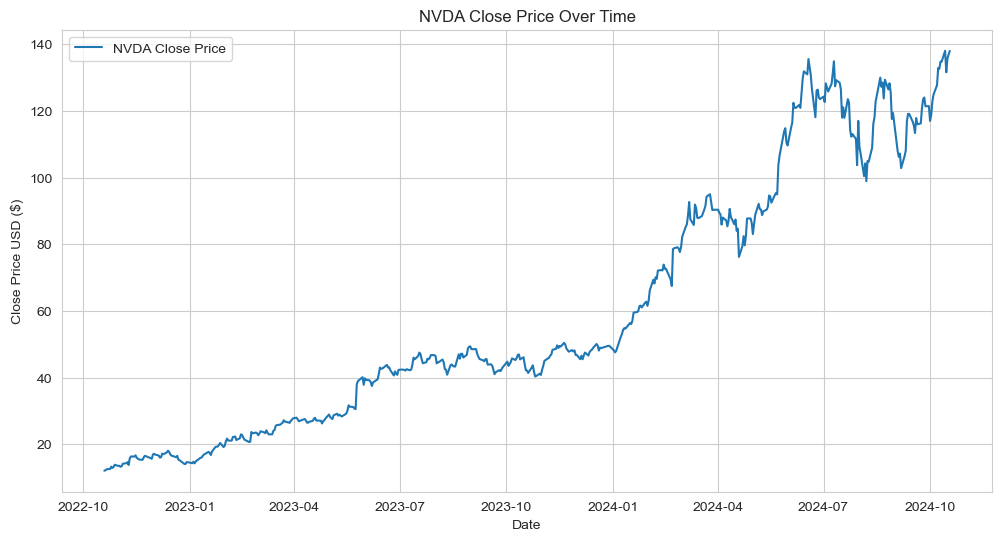

In [10]:
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label=f'{ticker} Close Price')
plt.title(f'{ticker} Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

In [11]:
print(data['Close'].describe())

count    503.000000
mean      59.836642
std       37.520912
min       12.051000
25%       27.507500
50%       46.566002
75%       90.063999
max      138.070007
Name: Close, dtype: float64


Features Engineering:

In [13]:
# Short-term moving average (7 days)
data.loc[:, 'MA7'] = data['Close'].rolling(window=7).mean()

# Long-term moving average (21 days)
data.loc[:, 'MA21'] = data['Close'].rolling(window=21).mean()

"""
Help to identify trends in the stock price data.
"""

The Relative Strength Index (RSI) is a momentum oscillator used in technical analysis to measure the speed and change of price movements of a financial asset. Developed by J. Welles Wilder Jr., the RSI helps traders identify overbought and oversold conditions in the market.

How RSI Works:

 - Oscillation Range: The RSI fluctuates between 0 and 100.
 - Overbought Conditions: An RSI reading above 70 typically indicates that an asset may be overbought or overvalued, suggesting a possible pullback.
 - Oversold Conditions: An RSI reading below 30 suggests that an asset may be oversold or undervalued, indicating a potential rebound.



In [15]:
def compute_rsi(data, time_window):
    """
    Compute the Relative Strength Index (RSI) for a given time window.
    Indicates overbought or oversold conditions.
    
    @param data: The closing prices of the stock.
    @param time_window: The time window for computing the RSI.
    @return: The RSI values for the stock.
    """
    diff = data.diff(1).dropna()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=time_window).mean()
    avg_loss = loss.rolling(window=time_window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data.loc[:, 'RSI'] = compute_rsi(data['Close'], 14)

In [17]:
# MACD calculation
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data.loc[:, 'MACD'] = exp1 - exp2
data.loc[:, 'Signal Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

"""
Shows the relationship between two moving averages to identify momentum.
"""

In [18]:
data.isna().sum()

Date            0
Close           0
MA7             6
MA21           20
RSI            14
MACD            0
Signal Line     0
dtype: int64

In [19]:
# After adding indicators, drop any remaining NaN values
data.dropna(inplace=True)

Prepare data for modeling:

In [21]:
# Define the feature set X and the target variable y
X = data[['Close', 'MA7', 'MA21', 'RSI', 'MACD', 'Signal Line']]
y = data['Close'].shift(-1)  # Predicting the next day's closing price

# Drop the last row as it will have NaN in the target variable
X = X[:-1]
y = y[:-1]


In [22]:
# Split data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False # Shuffle=False to preserve temporal order
)

In [23]:
# Scale the features to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
from sklearn.linear_model import LinearRegression

# Initialize the model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean Absolute Error (MAE)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# Root Mean Squared Error (RMSE)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Linear Regression MAE: {mae_lr}")
print(f"Linear Regression RMSE: {rmse_lr}")

Linear Regression MAE: 3.429065394267334
Linear Regression RMSE: 4.435637850735597


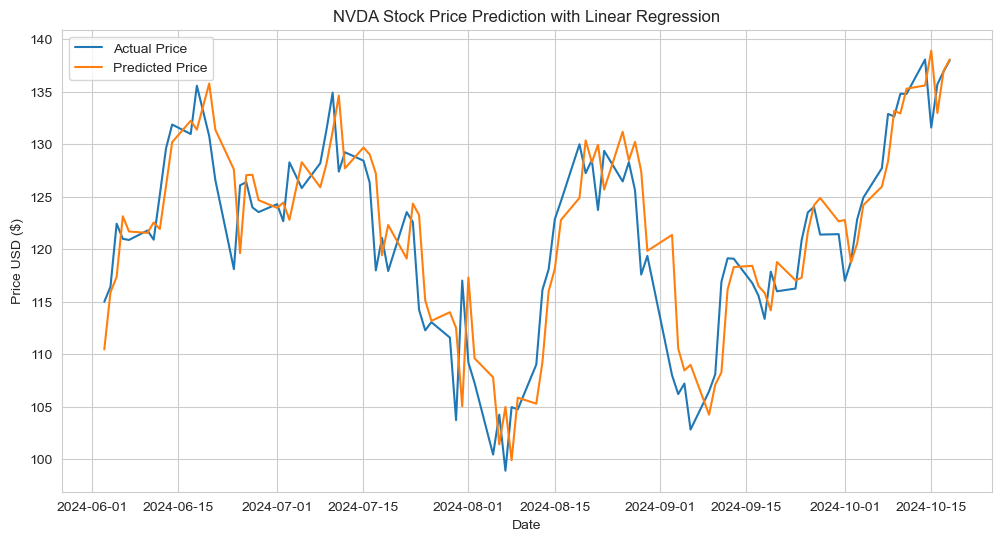

In [26]:
plt.figure(figsize=(12,6))
plt.plot(data['Date'][-len(y_test):], y_test, label='Actual Price')
plt.plot(data['Date'][-len(y_test):], y_pred_lr, label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction with Linear Regression')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.legend()
plt.show()